In [24]:
%load_ext autoreload
%autoreload 2
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scripts.plot import plot_df, plot_forecast, plot_acf_pacf
from scripts.stats import forecast_accuracy

df = pd.read_csv("./data/01_processed_output.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').asfreq('D')
df = df.temperature
df.tail()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


date
2022-03-27    20.9
2022-03-28    17.0
2022-03-29    18.7
2022-03-30    21.9
2022-03-31    23.5
Freq: D, Name: temperature, dtype: float64

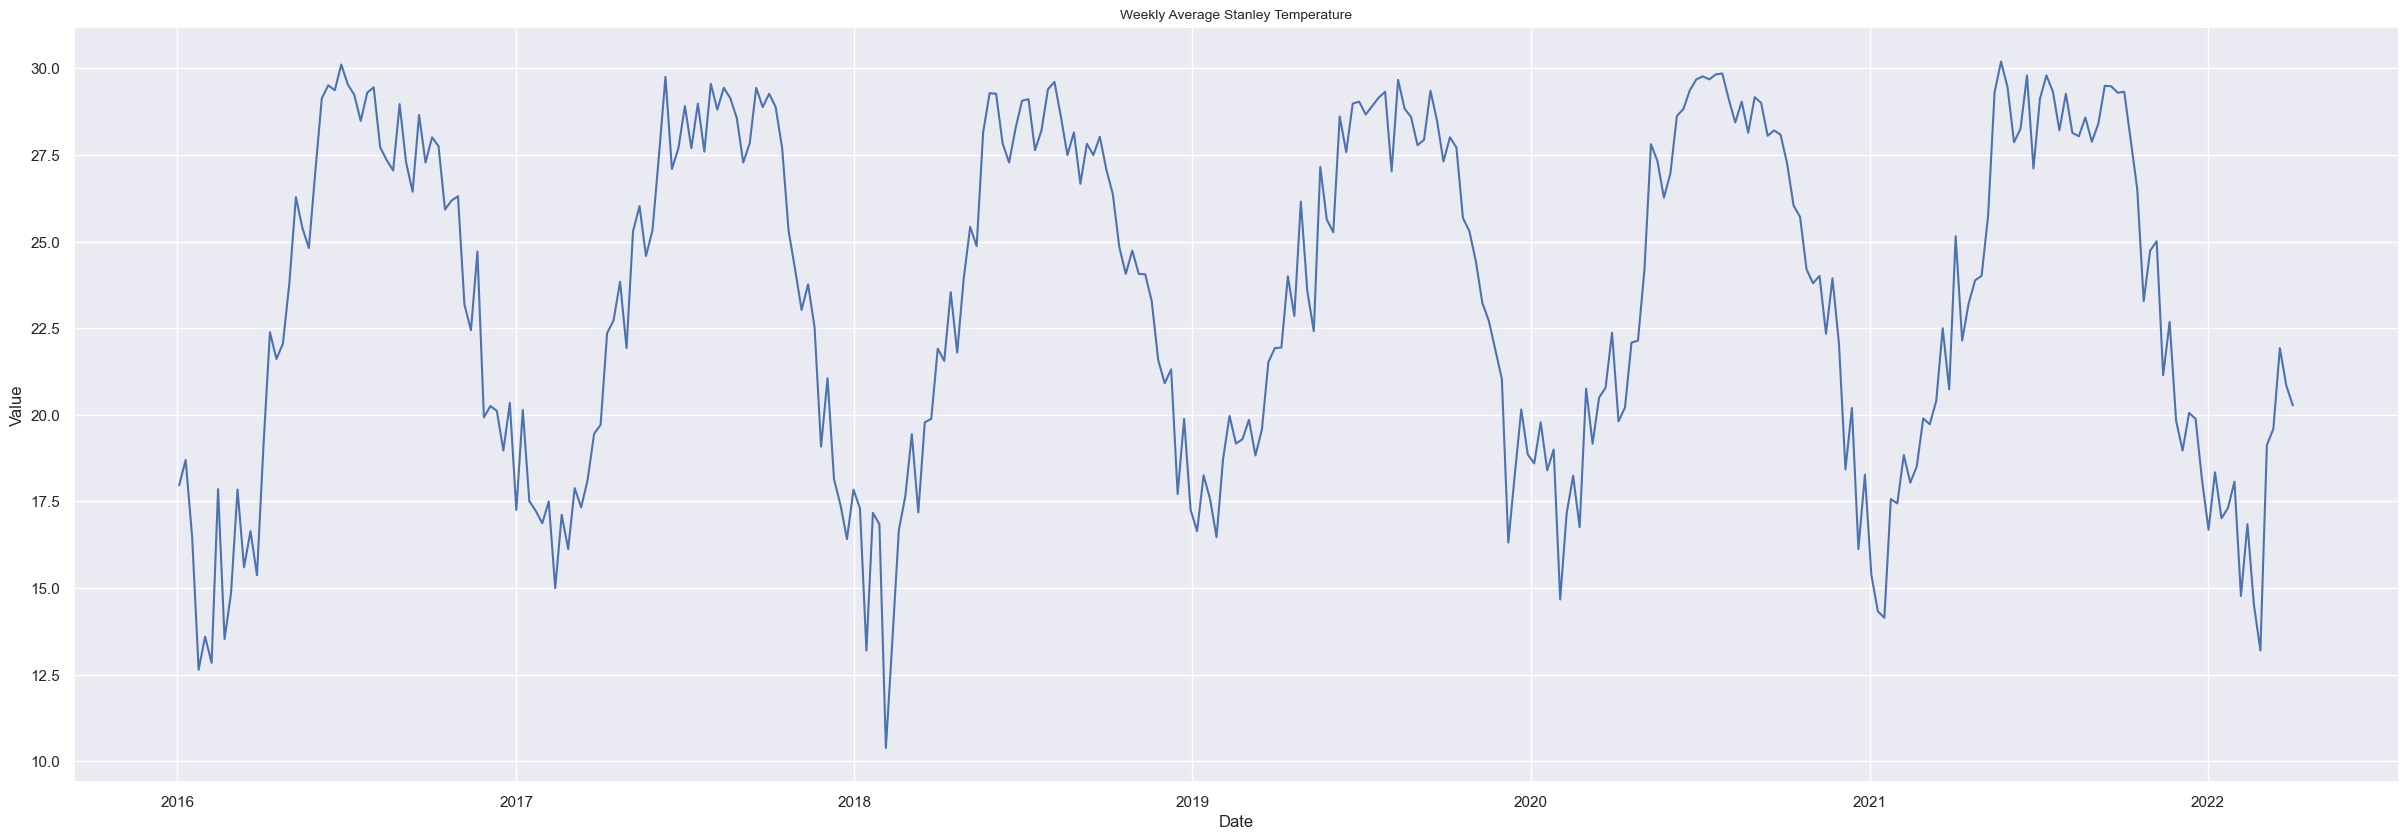

In [2]:
# Draw Plot
sns.set_theme()

start="2016-01-01"
range_df = df.loc[start:]
df_week = range_df.resample('W').mean()

# sns.lineplot(data=range_df,x=range_df.index,y=range_df.values)
plot_df(df_week, title='Weekly Average Stanley Temperature')  

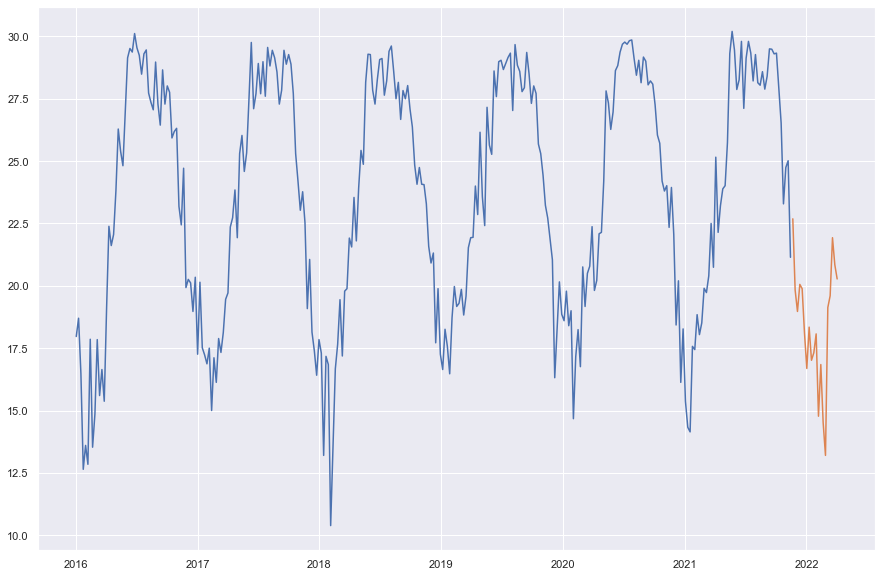

In [3]:
# Create Training and Test
test_size = 20  
train = df_week[:-test_size]
test = df_week[-test_size:]
# print(train[-5:])
# print(test)

plt.figure(figsize=(15, 10))
plt.plot(train[:])
plt.plot(test)


## Model fitting
Determine SARIMA model order using auto_arima, picking the best model in a stepwise manner with AIC as the minimization metric.

Results:
- SARIMA(1,0,1)(0,1,2)[52]
- with AIC=968.612

In [4]:
# stepwise_model = auto_arima(
#     train, D=1, seasonal=True, m = 52, trace=True, suppress_warnings=True, stepwise=True
# )

#  ARIMA(2,0,2)(1,1,1)[52] intercept   : AIC=969.078, Time=49.66 sec
#  ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=1074.004, Time=0.43 sec
#  ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=980.743, Time=7.60 sec
#  ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=7.76 sec
#  ARIMA(0,0,0)(0,1,0)[52]             : AIC=1074.537, Time=0.23 sec
#  ARIMA(2,0,2)(0,1,1)[52] intercept   : AIC=inf, Time=31.69 sec
#  ARIMA(2,0,2)(1,1,0)[52] intercept   : AIC=981.381, Time=24.03 sec
#  ARIMA(2,0,2)(2,1,1)[52] intercept   : AIC=970.577, Time=87.09 sec
#  ARIMA(2,0,2)(1,1,2)[52] intercept   : AIC=970.790, Time=96.49 sec
#  ARIMA(2,0,2)(0,1,0)[52] intercept   : AIC=1049.671, Time=6.76 sec
#  ARIMA(2,0,2)(0,1,2)[52] intercept   : AIC=968.794, Time=58.13 sec
#  ARIMA(1,0,2)(0,1,2)[52] intercept   : AIC=967.885, Time=42.17 sec
#  ARIMA(1,0,2)(0,1,1)[52] intercept   : AIC=inf, Time=19.14 sec
#  ARIMA(1,0,2)(1,1,2)[52] intercept   : AIC=969.861, Time=74.00 sec
#  ARIMA(1,0,2)(1,1,1)[52] intercept   : AIC=968.241, Time=19.92 sec
#  ARIMA(0,0,2)(0,1,2)[52] intercept   : AIC=971.202, Time=23.16 sec
#  ARIMA(1,0,1)(0,1,2)[52] intercept   : AIC=966.278, Time=33.09 sec
#  ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=18.14 sec
#  ARIMA(1,0,1)(1,1,2)[52] intercept   : AIC=968.236, Time=53.22 sec
#  ARIMA(1,0,1)(1,1,1)[52] intercept   : AIC=966.670, Time=15.45 sec
#  ARIMA(0,0,1)(0,1,2)[52] intercept   : AIC=970.015, Time=18.21 sec
#  ARIMA(1,0,0)(0,1,2)[52] intercept   : AIC=967.996, Time=25.68 sec
#  ARIMA(2,0,1)(0,1,2)[52] intercept   : AIC=968.031, Time=43.43 sec
#  ARIMA(0,0,0)(0,1,2)[52] intercept   : AIC=984.008, Time=12.70 sec
#  ARIMA(2,0,0)(0,1,2)[52] intercept   : AIC=968.969, Time=21.59 sec
#  ARIMA(1,0,1)(0,1,2)[52]             : AIC=968.612, Time=23.01 sec

# Best model:  ARIMA(1,0,1)(0,1,2)[52] intercept
# Total fit time: 812.898 seconds


In [17]:
auto_model = ARIMA(train, order=(1,0,1), seasonal_order=(0,1,2,52))
auto_fitted = auto_model.fit()  
auto_fitted.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                           temperature   No. Observations:                  307
Model:             ARIMA(1, 0, 1)x(0, 1, [1, 2], 52)   Log Likelihood                -479.306
Date:                               Tue, 26 Apr 2022   AIC                            968.612
Time:                                       09:59:27   BIC                            986.318
Sample:                                   01-03-2016   HQIC                           975.734
                                        - 11-14-2021                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7770      0.095      8.140      0.000       0.590       0.964
ma.L1         -0.5501      0.123     -4.479      0.000      -0.791      -0.309
ma.S.L52      -0.7360      0.068    -10.775      0.000      -0.870      -0.602
ma.S.L104      0.1903      0.078      2.429      0.015       0.037       0.344
sigma2         2.2421      0.222     10.098      0.000       1.807       2.677
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 2.75
Prob(Q):                              0.88   Prob(JB):                         0.25
Heteroskedasticity (H):               0.84   Skew:                            -0.17
Prob(H) (two-sided):                  0.43   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
auto_fitted.mse ** 0.5

9.89542098873982

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


,lb_stat,lb_pvalue
Lags,,
5,4.781521,0.443121
10,9.111748,0.521532
20,20.315217,0.438373
50,51.920347,0.398918


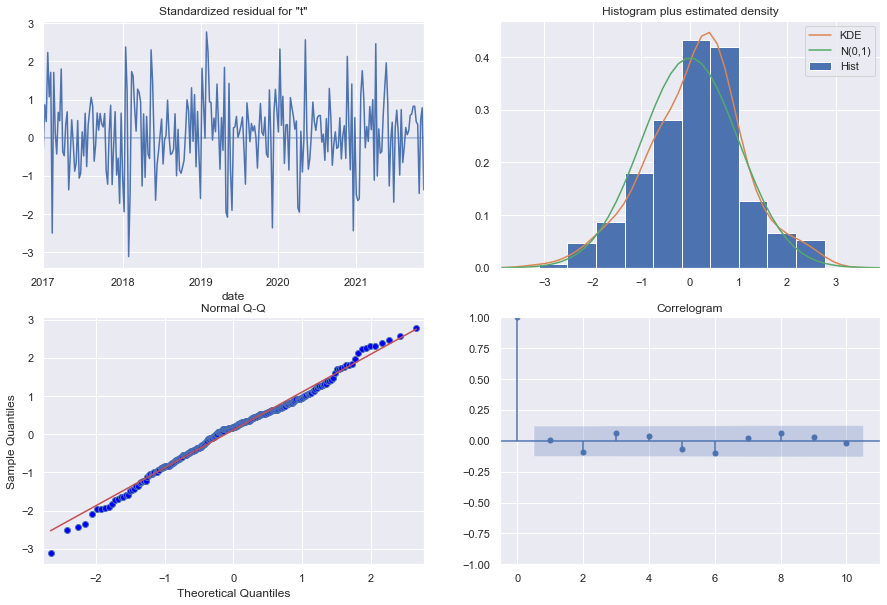

In [6]:
# Not accurate for some reason
# Have to use auto_fitted.standardized_forecasts_error[0] instead of auto_fitted.resid
# https://github.com/statsmodels/statsmodels/issues/7349
# But still not accurate
# acorr_ljungbox(auto_fitted.standardized_forecasts_error[0], period=52, model_df=auto_fitted.df_model, return_df=True)
# Definition
# https://github.com/statsmodels/statsmodels/blob/ad64444f4376483cb20f4432048dc8d73b830dcd/statsmodels/tsa/statespace/mlemodel.py

auto_fitted.plot_diagnostics(figsize=(15,10))
lags = [5,10,20,50]
lb_test = auto_fitted.test_serial_correlation(method="ljungbox", lags=lags)
# lb_test.shape
lb_test = pd.DataFrame({
            "lb_stat": lb_test[0][0], 
            "lb_pvalue": lb_test[0][1]
        }, index=lags)
lb_test.index.names = ["Lags"]
lb_test


### Seasonal ARIMA

$$SARIMA(p,d,q)(P,D,Q)m$$

Although a seasonal ARIMA model seems to have only a few parameters, that backforecasting requires the estimation of one or two seasons' worth of implicit parameters to initialize it. Therefore, we should have at least 4 or 5 seasons of data to fit a seasonal ARIMA model.

### "Seasonal Exponential Smoothing"

Probably the most commonly used seasonal ARIMA model is the (0,1,1)x(0,1,1) model--i.e., an MA(1)xSMA(1) model with both a seasonal and a non-seasonal difference. This is essentially a "seasonal exponential smoothing" model.

In [7]:
model = ARIMA(train, order=(1,0,0), seasonal_order=(0,1,1,52))
# model = ARIMA(train, order=(1,1,1))
fitted = model.fit()  
type(fitted)
print(fitted.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        temperature   No. Observations:                  307
Model:             ARIMA(1, 0, 0)x(0, 1, [1], 52)   Log Likelihood                -484.854
Date:                            Tue, 26 Apr 2022   AIC                            975.708
Time:                                    09:54:29   BIC                            986.332
Sample:                                01-03-2016   HQIC                           979.982
                                     - 11-14-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3215      0.054      5.988      0.000       0.216       0.427
ma.S.L52      -0.7020      0.098   

In [9]:
fitted.mse ** 0.5

9.900694084274491

In [12]:
model2 = ARIMA(train, order=(0,0,1), seasonal_order=(0,1,1,52))
fitted2 = model2.fit()  
fitted2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                      temperature   No. Observations:                  307
Model:             ARIMA(0, 0, 1)x(0, 1, 1, 52)   Log Likelihood                -487.228
Date:                          Tue, 26 Apr 2022   AIC                            980.456
Time:                                  09:56:33   BIC                            991.080
Sample:                              01-03-2016   HQIC                           984.729
                                   - 11-14-2021                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2786      0.054      5.179      0.000       0.173       0.384
ma.S.L52      -0.6833      0.097     -7.080      0.000      -0.872      -0.494
sigma2         2.3567      0.267      8.813      0.000       1.833       2.881
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.41
Prob(Q):                              0.99   Prob(JB):                         0.11
Heteroskedasticity (H):               0.84   Skew:                            -0.12
Prob(H) (two-sided):                  0.41   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
print(fitted2.mse ** 0.5)

9.90288049560163


In [14]:
model3 = ARIMA(train, order=(1,0,1), seasonal_order=(0,1,1,52))
fitted3 = model3.fit()  
fitted3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                      temperature   No. Observations:                  307
Model:             ARIMA(1, 0, 1)x(0, 1, 1, 52)   Log Likelihood                -481.334
Date:                          Tue, 26 Apr 2022   AIC                            970.669
Time:                                  09:57:25   BIC                            984.834
Sample:                              01-03-2016   HQIC                           976.367
                                   - 11-14-2021                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7670      0.093      8.217      0.000       0.584       0.950
ma.L1         -0.5212      0.123     -4.253      0.000      -0.761      -0.281
ma.S.L52      -0.7290      0.103     -7.087      0.000      -0.931      -0.527
sigma2         2.1968      0.262      8.379      0.000       1.683       2.711
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.58
Prob(Q):                              0.92   Prob(JB):                         0.10
Heteroskedasticity (H):               0.87   Skew:                            -0.20
Prob(H) (two-sided):                  0.53   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
fitted3.mse ** 0.5

9.897274073013996

## Overparametrised models

SARIMA(2,0,1)(0,1,1,52) 
- Non-stationary, Non-invertible

SARIMA(1,0,2)(0,1,1,52)
- AIC=972.278(worse)
- LB p-value 0.11, not rej
- MA(2) coeff = -0.0515, close to zero. P-value = 0.5, rejected

SARIMA(1,0,1)(0,1,2,52)
- AIC=968.612(improved)
- LB not rejected
- SMA(2) coeff = 0.1903, not close to zero. P-value < 0.0005, not rejected

SARIMA(1,0,1)(0,1,3,52)
- AIC=970.546(worse than sma(2))
- LB not rejected
- SMA(2) coeff = 0.0322, close to zero. P-value = 0.743, rejected



In [20]:
model3_ma2 = ARIMA(train, order=(1,0,2), seasonal_order=(0,1,1,52))
fitted3_ma2 = model3_ma2.fit()  
fitted3_ma2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        temperature   No. Observations:                  307
Model:             ARIMA(1, 0, 2)x(0, 1, [1], 52)   Log Likelihood                -481.139
Date:                            Tue, 26 Apr 2022   AIC                            972.278
Time:                                    11:41:30   BIC                            989.984
Sample:                                01-03-2016   HQIC                           979.400
                                     - 11-14-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8034      0.125      6.423      0.000       0.558       1.049
ma.L1         -0.5339      0.139     -3.853      0.000      -0.806      -0.262
ma.L2         -0.0515      0.078     -0.661      0.509      -0.204       0.101
ma.S.L52      -0.7315      0.104     -7.049      0.000      -0.935      -0.528
sigma2         2.1904      0.262      8.365      0.000       1.677       2.704
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 4.43
Prob(Q):                              0.84   Prob(JB):                         0.11
Heteroskedasticity (H):               0.88   Skew:                            -0.19
Prob(H) (two-sided):                  0.57   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
fitted3_ma2.mse ** 0.5

9.89714855989666

In [22]:
model3_sma3 = ARIMA(train, order=(1,0,1), seasonal_order=(0,1,3,52))
fitted3_sma3 = model3_sma3.fit()  
type(fitted3_sma3)
print(fitted3_sma3.summary())
print(fitted3_sma3.mse ** 0.5)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                        SARIMAX Results                                         
Dep. Variable:                              temperature   No. Observations:                  307
Model:             ARIMA(1, 0, 1)x(0, 1, [1, 2, 3], 52)   Log Likelihood                -479.273
Date:                                  Tue, 26 Apr 2022   AIC                            970.546
Time:                                          11:44:26   BIC                            991.793
Sample:                                      01-03-2016   HQIC                           979.093
                                           - 11-14-2021                                         
Covariance Type:                                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7774      0.095      8.202      0.000       0.592

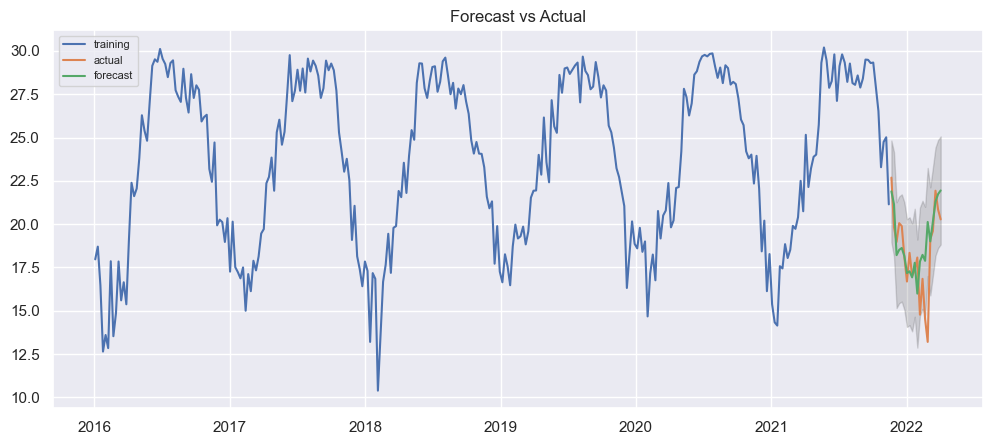

In [23]:
plot_forecast(auto_fitted,test)

In [28]:
forecast_accuracy(auto_fitted, test.values)

c:\Users\Victor\Documents\school\yr 3 sem 2\STAT4601 Time-series analysis\Project\stat4601-project-master\stat4601-project\scripts\stats.py:73: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([fc[:, None], actual[:, None]]), axis=1)
c:\Users\Victor\Documents\school\yr 3 sem 2\STAT4601 Time-series analysis\Project\stat4601-project-master\stat4601-project\scripts\stats.py:74: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([fc[:, None], actual[:, None]]), axis=1)


{'mape': 0.0876092076514692,
 'me': 0.5894561079885021,
 'mae': 1.4245016437543403,
 'mpe': 0.04468690042530349,
 'rmse': 2.0944134422699228,
 'corr': 0.5662204746467351,
 'minmax': 0.07358374979294524}

## Model Diagnostic

                                SARIMAX Results                                 
Dep. Variable:              temperature   No. Observations:                  307
Model:             ARIMA(0, 1, [1], 52)   Log Likelihood                -498.539
Date:                  Sun, 24 Apr 2022   AIC                           1001.078
Time:                          15:01:20   BIC                           1008.160
Sample:                      01-03-2016   HQIC                          1003.927
                           - 11-14-2021                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L52      -0.6446      0.089     -7.270      0.000      -0.818      -0.471
sigma2         2.6219      0.293      8.945      0.000       2.047       3.196
Ljung-Box (L1) (Q):                 

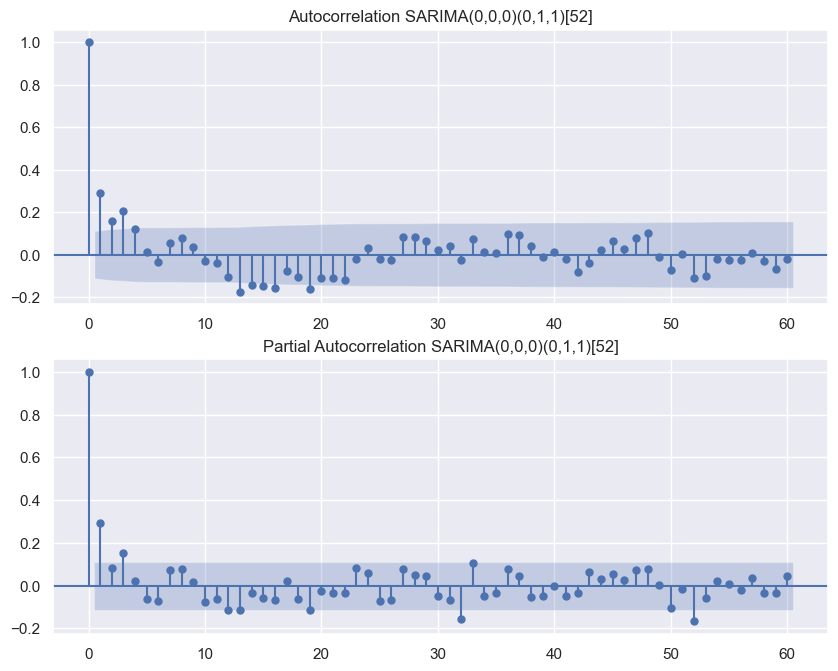

In [88]:
model = ARIMA(train, order=(0,0,0), seasonal_order=(0,1,1,52))
fitted = model.fit()  
print(fitted.summary())
# plot_acf_pacf(fitted.standardized_forecasts_error[0], n_lags=60, title_suffix="SARIMA(1,0,1)(0,1,2)[52]")
plot_acf_pacf(fitted.standardized_forecasts_error[0], n_lags=60, title_suffix="SARIMA(0,0,0)(0,1,1)[52]")